## Titanic: Machine Learning from Disaster

The aim is to predict a given person if he/she died or not. I downloaded the data with Kaggle API `kaggle competitions download -c titanic`

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

%matplotlib inline 

In [2]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df_submit = pd.read_csv('./gender_submission.csv')

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


* Check NULL amounts in columns.

In [3]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


I mostly do not look data set a lot not to overfit model, but I think that there is absolutely `correlation` between Pclass and Survived.

In [6]:
df_train.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

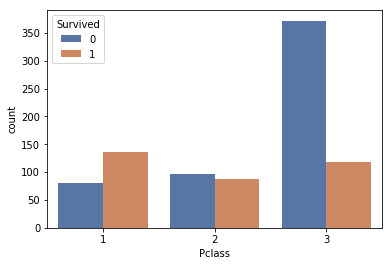

In [7]:
sns.countplot(x='Pclass', data=df_train, hue='Survived', palette='deep')
plt.show()

## Feature Engineering

Now, it is time to extract some useful data

In [8]:
df_train["Age"] = df_train["Age"].fillna(df_train["Age"].median())
df_test["Age"] = df_test["Age"].fillna(df_test["Age"].median())

In [9]:
df_train.loc[df_train["Sex"] == "male", "Sex"] = 0
df_test.loc[df_test["Sex"] == "male", "Sex"] = 0

In [10]:
df_train.loc[df_train["Sex"] == "female", "Sex"] = 1
df_test.loc[df_test["Sex"] == "female", "Sex"] = 1

In [11]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
df_train['Embarked'] = df_train['Embarked'].fillna('S')

In [13]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [14]:
df_train = pd.get_dummies(df_train, columns=["Embarked"])
df_test = pd.get_dummies(df_test, columns=["Embarked"])

# Drop unnecessary features
df_train = df_train.drop(["Name", "PassengerId", "Cabin", "Ticket"], axis=1)
df_test = df_test.drop(["Name", "PassengerId", "Cabin", "Ticket"], axis=1)

In [15]:
X = df_train.drop(["Survived"], axis=1)
y = df_train["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
xg = XGBClassifier(max_depth = 2, n_estimators = 400, learning_rate = 0.1)
xg.fit(X_train, y_train)

results = cross_validate(xg, X_train, y_train)
results['test_score']  

y_pred = xg.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8379888268156425


/home/orhan/anaconda3/envs/shield-py-2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


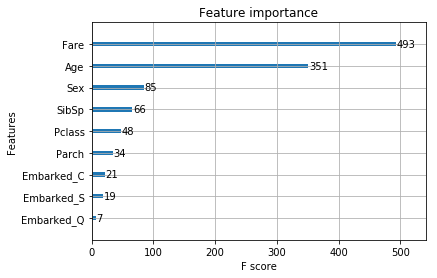

In [17]:
plot_importance(xg)

* Ready for submission

You need to export a .csv file for Kaggle.

In [18]:
cv_results = cross_validate(xg, X, y)
predictions = xg.predict(df_test)

In [20]:
df_submit["Survived"] = predictions
df_submit.to_csv("xgboost_submission.csv", index=False)